In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

In [38]:
# load all data
energy = pd.read_csv('household_power_consumption.txt',sep=';', na_values="?")

Text(0.5, 1.0, 'Single Household Energy Consumption Hourly')

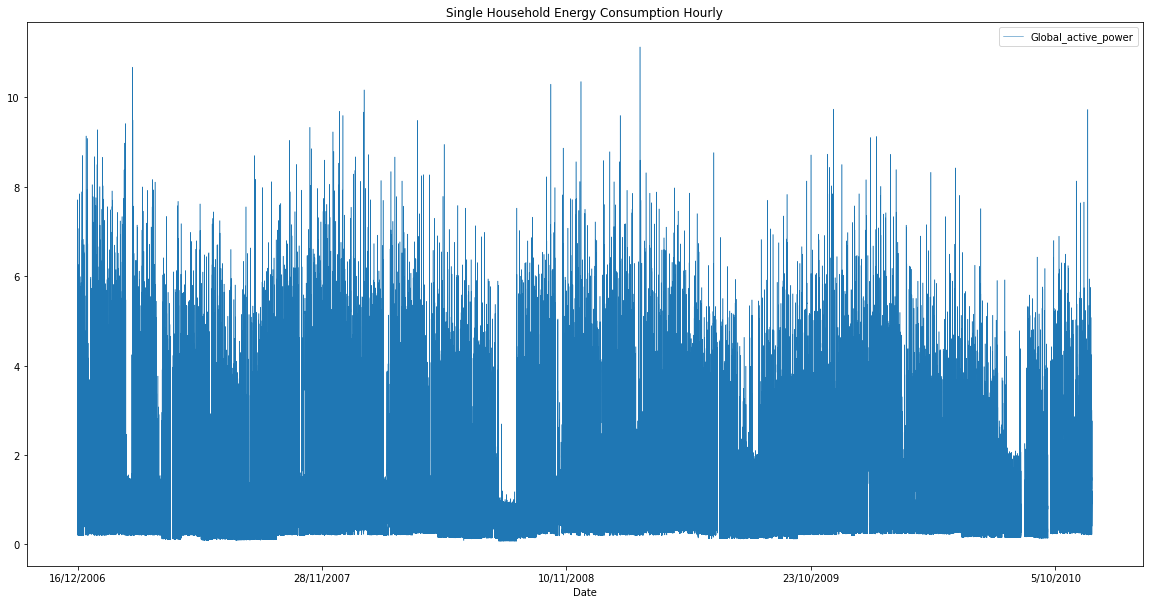

In [39]:
from matplotlib.pyplot import figure

energy.plot(x='Date',y='Global_active_power',lw = 0.5,figsize=(20,10))
plt.title("Single Household Energy Consumption Hourly")

In [58]:
dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

#Deal with missing values
energy = energy.fillna(method='ffill')
energy.isnull().sum()

Date_Time              0
Date                   0
Year                   0
Month                  0
Day                    0
Hour                   0
Time                   0
Global_active_power    0
dtype: int64

In [59]:
#Insert additional columns
energy.insert(0, 'Date_Time', pd.to_datetime(energy['Date'] + ' ' + energy['Time'])) #datetime format
energy.insert(2, 'Year',energy['Date_Time'].dt.year) #year
energy.insert(3, 'Month',energy['Date_Time'].dt.month) #month
energy.insert(4, 'Day',energy['Date_Time'].dt.weekday) #weekday_name
energy.insert(5, 'Hour',energy['Date_Time'].dt.hour) #hour

#Exclude other numerical variables (univariate analysis)
energy = energy.iloc[:,0:8]

#Preview data
energy.head()

ValueError: cannot insert Date_Time, already exists

In [42]:
np.round(energy['Global_active_power'].describe(), 2).apply(lambda x: format(x, 'f'))

count    2075259.000000
mean           1.090000
std            1.050000
min            0.080000
25%            0.310000
50%            0.600000
75%            1.520000
max           11.120000
Name: Global_active_power, dtype: object

In [7]:
from sklearn import preprocessing

#summarize by mean hourly energy
energy_hourly_summary = energy.groupby(
    by=['Year','Month','Day',"Hour"], as_index=False)[['Global_active_power']].mean()

#create the Label Encoder object
le = preprocessing.LabelEncoder()

#encode categorical data
energy_hourly_summary['Year'] = le.fit_transform(energy_hourly_summary['Year'])
energy_hourly_summary.head()

,Year,Month,Day,Hour,Global_active_power
0,0,12,0,0,0.637967
1,0,12,0,1,0.760033
2,0,12,0,2,0.361233
3,0,12,0,3,0.449950
4,0,12,0,4,0.802500


In [8]:
indexed_engery = energy[['Date_Time','Global_active_power', 'Year', 'Month']].set_index('Date_Time');
train = indexed_engery[indexed_engery['Year'] < 2010] #train set is years 2006 - 2009
test = indexed_engery[indexed_engery['Year'] == 2010] #test set is year 2010

# Define test and train data for weekly power consumption
train_weekly=train[['Global_active_power']].resample('W').mean() 
test_weekly=test[['Global_active_power']].resample('W').mean() 
print('\nShape of Train Dataset = (%s, %s)'%(train_weekly.shape))
print('\nShape of Test Dataset = (%s, %s)'%(test_weekly.shape))


Shape of Train Dataset = (160, 1)

Shape of Test Dataset = (50, 1)


In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

def arimaForecast(arima, order, split_ratio = 0.7, yhatFlag=True):
    warnings.filterwarnings("ignore")
    X = arima.values
    size =round(len(arima) * split_ratio)
#     print(size)
    train, test = X[0:size], X[size:]
    history = [x for x in train]
#     print(history)
    predictions = list()
#     print(order)
    for t in range(len(test)):
        model = ARIMA(history, order = order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
#         print(test)
    error = sqrt(mean_squared_error(test, predictions))
#     print(error)
    return error, train, test, predictions, history



def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse, _,_,_,_ = arimaForecast(dataset, order, split_ratio=0.51)
#                     print(mse)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
p_values = [0,1,2,3,4,5,6,7]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(train_weekly, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.276
ARIMA(0, 0, 1) RMSE=0.246
ARIMA(0, 0, 2) RMSE=0.227
ARIMA(0, 1, 0) RMSE=0.257
ARIMA(0, 1, 1) RMSE=0.236
ARIMA(0, 1, 2) RMSE=0.232
ARIMA(0, 2, 0) RMSE=0.413
ARIMA(0, 2, 1) RMSE=0.259
ARIMA(0, 2, 2) RMSE=0.246
ARIMA(1, 0, 0) RMSE=0.232
ARIMA(1, 0, 1) RMSE=0.234
ARIMA(1, 0, 2) RMSE=0.230
ARIMA(1, 1, 0) RMSE=0.247
ARIMA(1, 1, 1) RMSE=0.232
ARIMA(1, 1, 2) RMSE=0.232
ARIMA(1, 2, 0) RMSE=0.331
ARIMA(1, 2, 1) RMSE=0.249
ARIMA(1, 2, 2) RMSE=0.243
ARIMA(2, 0, 0) RMSE=0.232
ARIMA(2, 0, 1) RMSE=0.227
ARIMA(2, 0, 2) RMSE=0.230
ARIMA(2, 1, 0) RMSE=0.247
ARIMA(2, 1, 1) RMSE=0.233
ARIMA(2, 1, 2) RMSE=0.239
ARIMA(2, 2, 0) RMSE=0.328
ARIMA(2, 2, 1) RMSE=0.250
ARIMA(2, 2, 2) RMSE=0.253
ARIMA(3, 0, 0) RMSE=0.234
ARIMA(3, 0, 1) RMSE=0.230
ARIMA(3, 0, 2) RMSE=0.232
ARIMA(3, 1, 0) RMSE=0.221
ARIMA(3, 1, 1) RMSE=0.222
ARIMA(3, 1, 2) RMSE=0.225
ARIMA(3, 2, 0) RMSE=0.276
ARIMA(3, 2, 1) RMSE=0.226
ARIMA(3, 2, 2) RMSE=0.230
ARIMA(4, 0, 0) RMSE=0.218
ARIMA(4, 0, 1) RMSE=0.219
ARIMA(4, 0, 

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

AR_model = ARIMA(train_weekly, order=(5,0,1))
AR_model_results = AR_model.fit()
# AR_model_results.forecast()

AR_predictions = AR_model_results.predict(start='2010-01-03', end='2010-12-19')
AR_predictions.shape

(51,)

In [44]:
test[['Global_active_power']].resample('W').mean().reset_index()
AR_prediction = pd.DataFrame(AR_predictions).reset_index()
AR_prediction.columns = ['Date_Time','Global_active_power']

AR_res = pd.merge(test[['Global_active_power']].resample('W').mean(), 
               AR_prediction, 
               how='left', 
               on='Date_Time')

AR_res.columns = ['Date_Time','actual','predictions']
AR_res.insert(3, 'residuals', AR_res['actual'] - AR_res['predictions']) #residuals
AR_res.head()

,Date_Time,actual,predictions,residuals
0,2010-01-03,0.976101,1.327329,-0.351228
1,2010-01-10,0.920572,1.295624,-0.375052
2,2010-01-17,1.451530,1.188677,0.262852
3,2010-01-24,1.535291,1.277411,0.257880
4,2010-01-31,1.548028,1.359815,0.188213


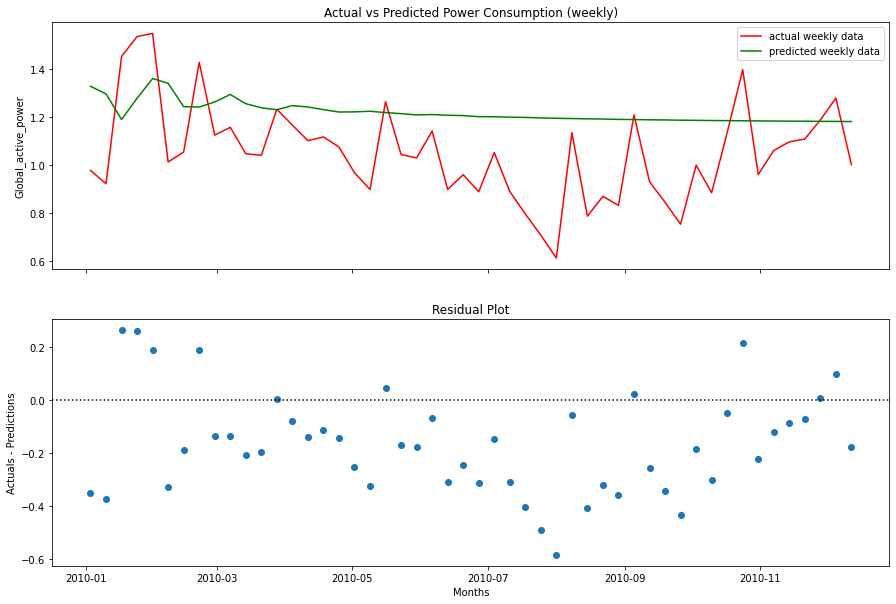

In [45]:
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)

#plot of actual vs predictions
axes[0].plot(AR_res['Date_Time'],AR_res['actual'], color='red', label='actual weekly data')
axes[0].plot(AR_res['Date_Time'],AR_res['predictions'], color='green', label='predicted weekly data')
axes[0].set_title('Actual vs Predicted Power Consumption (weekly)')
axes[0].set_ylabel('Global_active_power')
axes[0].legend()

#plot of actual - predictions
axes[1].scatter(AR_res['Date_Time'],(AR_res['actual'] - AR_res['predictions']))
axes[1].set_title('Residual Plot')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Actuals - Predictions')
axes[1].axhline(y=0, color='black', linestyle=':')

plt.show()

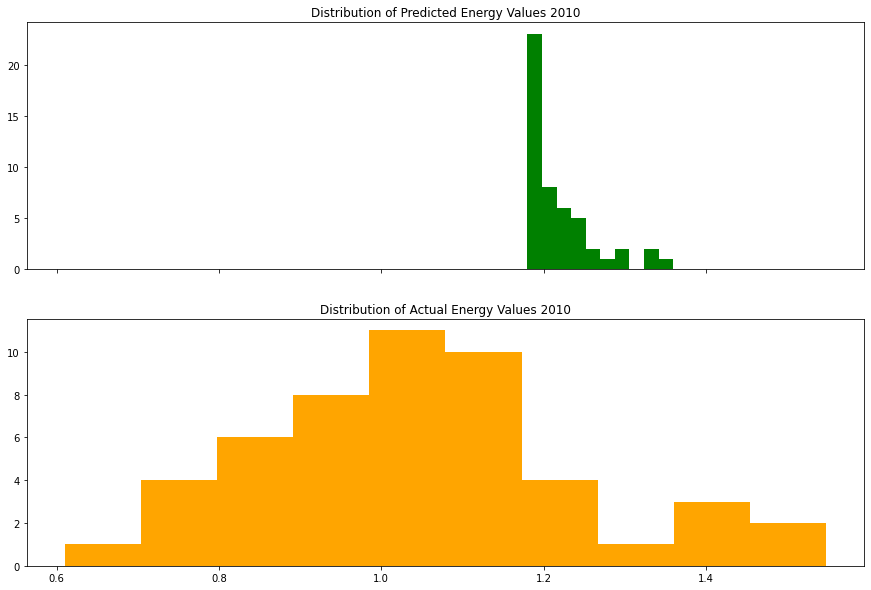

In [46]:
# predictions.index
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)
axes[0].hist(AR_res['predictions'].values, bins=10,color='green')
axes[0].set_title("Distribution of Predicted Energy Values 2010")
axes[1].hist((test_weekly[['Global_active_power']].resample('W').mean().values), bins=10,color='Orange')
axes[1].set_title("Distribution of Actual Energy Values 2010")
plt.show()

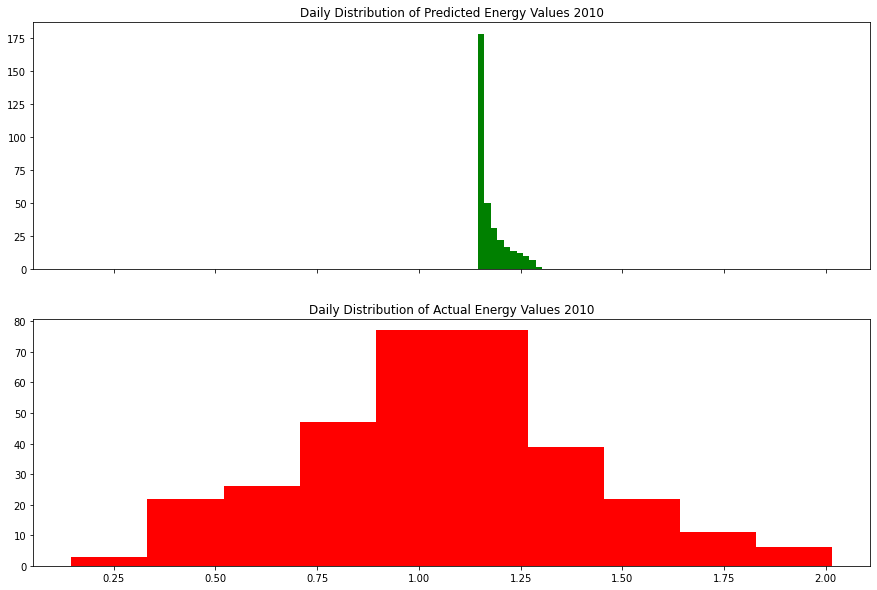

In [60]:
# predictions.index
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)
axes[0].hist(AR_res_d['predictions'].values, bins=10,color='green')
axes[0].set_title("Daily Distribution of Predicted Energy Values 2010")
axes[1].hist((test_daily[['Global_active_power']].resample('D').mean().values), bins=10,color='red')
axes[1].set_title("Daily Distribution of Actual Energy Values 2010")
plt.show()

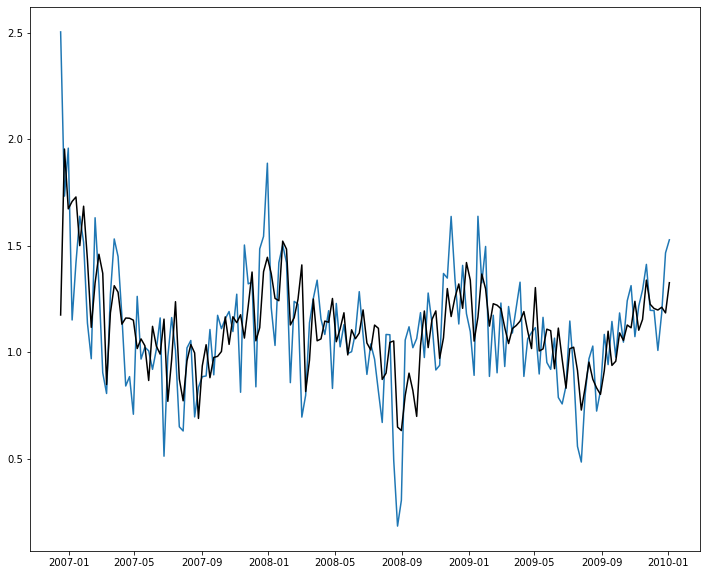

In [17]:
#Weekly
plt.figure(figsize=(12,10))
AR_model = ARIMA(train_weekly, order=(5,0,1))
AR_model_results = AR_model.fit()
plt.plot(train_weekly)
plt.plot(AR_model_results.fittedvalues, color='black')

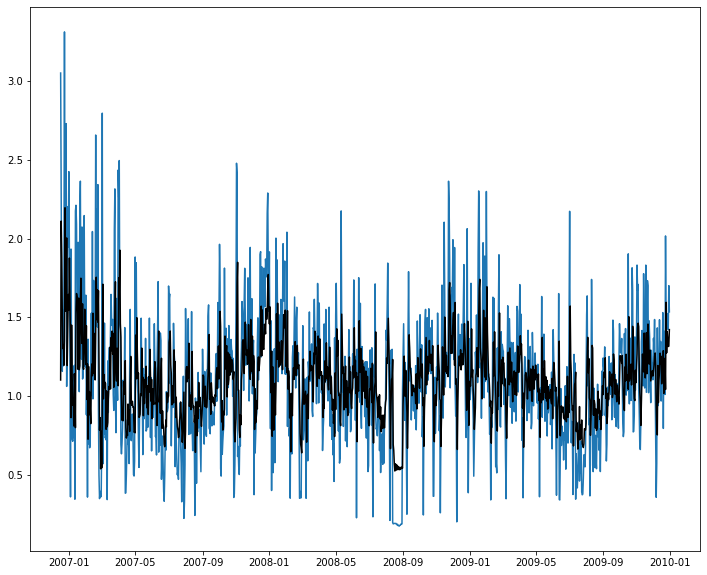

In [21]:
#Daily
plt.figure(figsize=(12,10))
AR_model = ARIMA(train_daily, order=(5,0,1))
AR_model_results = AR_model.fit()
plt.plot(train_daily)
plt.plot(AR_model_results.fittedvalues, color='black')

In [19]:
# accuracy measures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
MSE = mean_squared_error(AR_res['actual'], AR_res['predictions'])
MAE = mean_absolute_error(AR_res['actual'], AR_res['predictions'])
R2 = r2_score(AR_res['actual'], AR_res['predictions'])
RMSE = math.sqrt(MSE)
#print("RMSE:\n",RMSE)
print(f'\nMSE : {MSE}, RMSE : {RMSE}, MAE: {MAE}, R2: {R2}\n ')
print("Mean Absolute Percentage Error:\n", mean_absolute_percentage_error(AR_res['actual'], AR_res['predictions']))


MSE : 0.06441412640529123, RMSE : 0.25379938220037346, MAE: 0.21808532038820824, R2: -0.6081741142161998
 
Mean Absolute Percentage Error:
 0.2349373102410964


## Daily

In [47]:
indexed_engery = energy[['Date_Time','Global_active_power', 'Year', 'Month']].set_index('Date_Time');
train = indexed_engery[indexed_engery['Year'] < 2010] #train set is years 2006 - 2009
test = indexed_engery[indexed_engery['Year'] == 2010] #test set is year 2010

# Define test and train data for weekly power consumption
train_daily=train[['Global_active_power']].resample('D').mean() 
test_daily=test[['Global_active_power']].resample('D').mean() 
print('\nShape of Train Dataset = (%s, %s)'%(train_weekly.shape))
print('\nShape of Test Dataset = (%s, %s)'%(test_weekly.shape))


Shape of Train Dataset = (160, 1)

Shape of Test Dataset = (50, 1)


In [18]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

def arimaForecast(arima, order, split_ratio = 0.7, yhatFlag=True):
    warnings.filterwarnings("ignore")
    X = arima.values
    size =round(len(arima) * split_ratio)
#     print(size)
    train, test = X[0:size], X[size:]
    history = [x for x in train]
#     print(history)
    predictions = list()
#     print(order)
    for t in range(len(test)):
        model = ARIMA(history, order = order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
#         print(test)
    error = sqrt(mean_squared_error(test, predictions))
#     print(error)
    return error, train, test, predictions, history



def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse, _,_,_,_ = arimaForecast(dataset, order, split_ratio=0.51)
#                     print(mse)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
p_values = [0,1,2,3,4,5,6,7]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(train_daily, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.405
ARIMA(0, 0, 1) RMSE=0.349
ARIMA(0, 0, 2) RMSE=0.339
ARIMA(0, 1, 0) RMSE=0.370
ARIMA(0, 1, 1) RMSE=0.350
ARIMA(0, 1, 2) RMSE=0.332
ARIMA(0, 2, 0) RMSE=0.577
ARIMA(0, 2, 1) RMSE=0.370
ARIMA(0, 2, 2) RMSE=0.351
ARIMA(1, 0, 0) RMSE=0.332
ARIMA(1, 0, 1) RMSE=0.333
ARIMA(1, 0, 2) RMSE=0.331
ARIMA(1, 1, 0) RMSE=0.364
ARIMA(1, 1, 1) RMSE=0.327
ARIMA(1, 1, 2) RMSE=0.328
ARIMA(1, 2, 0) RMSE=0.499
ARIMA(1, 2, 1) RMSE=0.364
ARIMA(1, 2, 2) RMSE=0.329
ARIMA(2, 0, 0) RMSE=0.333
ARIMA(2, 0, 1) RMSE=0.327
ARIMA(2, 0, 2) RMSE=0.328
ARIMA(2, 1, 0) RMSE=0.355
ARIMA(2, 1, 1) RMSE=0.329
ARIMA(2, 1, 2) RMSE=0.328
ARIMA(2, 2, 0) RMSE=0.459
ARIMA(2, 2, 1) RMSE=0.355
ARIMA(2, 2, 2) RMSE=0.362
ARIMA(3, 0, 0) RMSE=0.333
ARIMA(3, 0, 1) RMSE=2.810
ARIMA(3, 0, 2) RMSE=0.329
ARIMA(3, 1, 0) RMSE=0.348
ARIMA(3, 1, 1) RMSE=0.329
ARIMA(3, 1, 2) RMSE=0.328
ARIMA(3, 2, 0) RMSE=0.429
ARIMA(3, 2, 1) RMSE=0.349
ARIMA(3, 2, 2) RMSE=0.353
ARIMA(4, 0, 0) RMSE=0.332
ARIMA(4, 0, 1) RMSE=0.332
ARIMA(4, 0, 

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

AR_model_d = ARIMA(train_daily, order=(2, 0, 1))
AR_model_results_d = AR_model_d.fit()
# AR_model_results.forecast()

AR_predictions_d = AR_model_results_d.predict(start='2010-01-03', end='2010-12-19')
AR_predictions_d.shape

(351,)

In [23]:
test[['Global_active_power']].resample('D').mean().reset_index()
AR_prediction_d = pd.DataFrame(AR_predictions_d).reset_index()
AR_prediction_d.columns = ['Date_Time','Global_active_power']

AR_res_d = pd.merge(test[['Global_active_power']].resample('D').mean(), 
               AR_prediction_d, 
               how='left', 
               on='Date_Time')

AR_res_d.columns = ['Date_Time','actual','predictions']
AR_res_d.insert(3, 'residuals', AR_res_d['actual'] - AR_res_d['predictions']) #residuals
AR_res_d.head()

,Date_Time,actual,predictions,residuals
0,2010-01-01,0.850175,NaN,NaN
1,2010-01-02,1.176235,NaN,NaN
2,2010-01-03,0.901894,1.303176,-0.401281
3,2010-01-04,1.171833,1.291402,-0.119569
4,2010-01-05,0.916776,1.285526,-0.368749


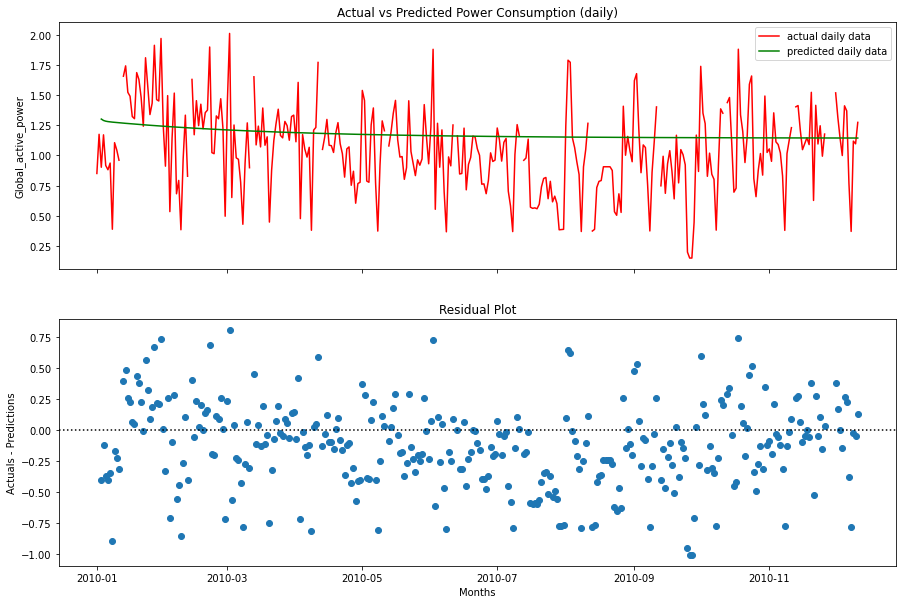

In [24]:
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)

#plot of actual vs predictions
axes[0].plot(AR_res_d['Date_Time'],AR_res_d['actual'], color='red', label='actual daily data')
axes[0].plot(AR_res_d['Date_Time'],AR_res_d['predictions'], color='green', label='predicted daily data')
axes[0].set_title('Actual vs Predicted Power Consumption (daily)')
axes[0].set_ylabel('Global_active_power')
axes[0].legend()

#plot of actual - predictions
axes[1].scatter(AR_res_d['Date_Time'],(AR_res_d['actual'] - AR_res_d['predictions']))
axes[1].set_title('Residual Plot')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Actuals - Predictions')
axes[1].axhline(y=0, color='black', linestyle=':')

plt.show()

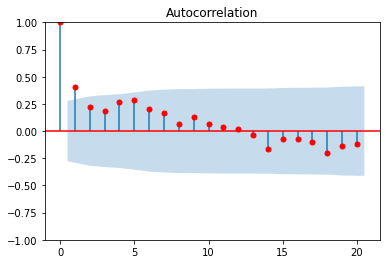

In [37]:
#acf Weekly
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ACF
plot_acf(test_weekly.values, lags = 20, color='red')
plt.show()

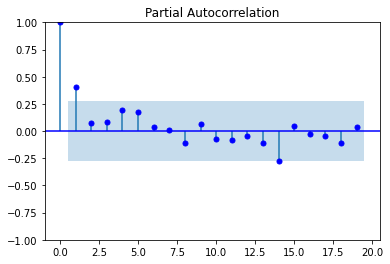

In [41]:
#PACF Daily
plot_pacf(test_weekly, lags = range(0, 20), method = "ols", color="blue")
plt.show()

In [43]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(test_weekly)
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print(f'No. of lags used: {adf[2]}')
print(f'No. of observations used : {adf[3]}')
print('Critical Values:')
for k, v in adf[4].items():
    print(f'   {k}: {v}') 

ADF Statistic: -4.463502164567438
p-value: 0.00022875708499563448
No. of lags used: 0
No. of observations used : 49
Critical Values:
   1%: -3.5714715250448363
   5%: -2.922629480573571
   10%: -2.5993358475635153


In [44]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(train_weekly)
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print(f'No. of lags used: {adf[2]}')
print(f'No. of observations used : {adf[3]}')
print('Critical Values:')
for k, v in adf[4].items():
    print(f'   {k}: {v}') 

ADF Statistic: -3.8197959065910987
p-value: 0.0027111482568678335
No. of lags used: 3
No. of observations used : 156
Critical Values:
   1%: -3.4729792729247793
   5%: -2.8802520918255534
   10%: -2.5767469641683105


In [46]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(test_weekly['Global_active_power'])
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print(f'No. of lags used: {adf[2]}')
print(f'No. of observations used : {adf[3]}')
print('Critical Values:')
for k, v in adf[4].items():
    print(f'   {k}: {v}') 

ADF Statistic: -4.463502164567438
p-value: 0.00022875708499563448
No. of lags used: 0
No. of observations used : 49
Critical Values:
   1%: -3.5714715250448363
   5%: -2.922629480573571
   10%: -2.5993358475635153


In [47]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(train_weekly['Global_active_power'])
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print(f'No. of lags used: {adf[2]}')
print(f'No. of observations used : {adf[3]}')
print('Critical Values:')
for k, v in adf[4].items():
    print(f'   {k}: {v}') 

ADF Statistic: -3.8197959065910987
p-value: 0.0027111482568678335
No. of lags used: 3
No. of observations used : 156
Critical Values:
   1%: -3.4729792729247793
   5%: -2.8802520918255534
   10%: -2.5767469641683105


In [1]:
#acf Weekly
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ACF
plot_acf(test_daily.values, lags = 20, color='red')
plt.show()

NameError: name 'test_daily' is not defined

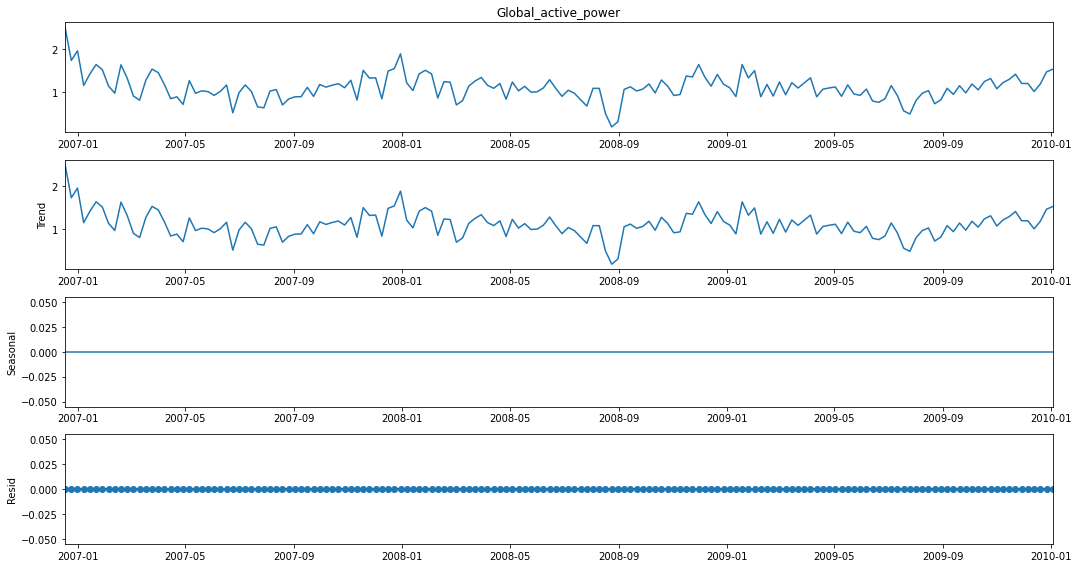

In [29]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(x = train_weekly["Global_active_power"], model='additive', period = 1)
decompose_series.plot()
plt.show()

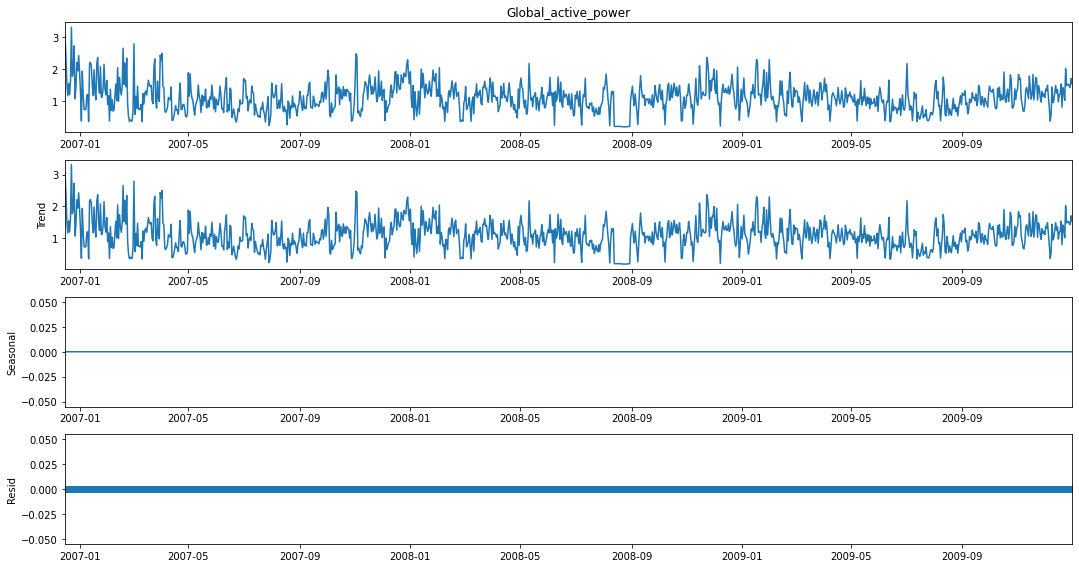

In [30]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(x = train_daily["Global_active_power"], model='additive', period = 1)
decompose_series.plot()
plt.show()

In [31]:
df_seas = pd.DataFrame(energy["Global_active_power"])
df_seas.head()

,Global_active_power
0,4.216
1,5.360
2,5.374
3,5.388
4,3.666


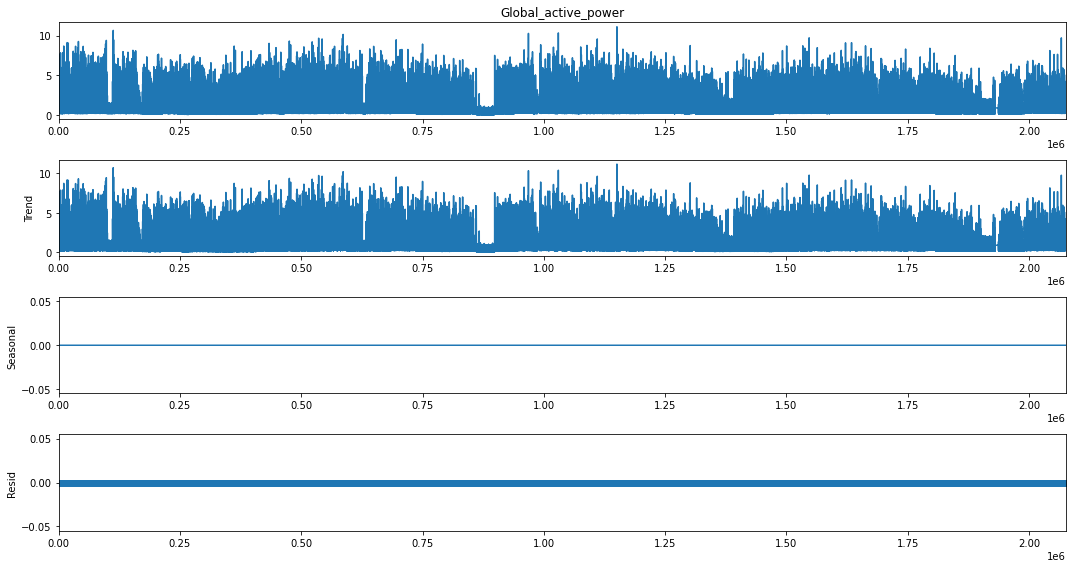

In [33]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(x = df_seas["Global_active_power"], model='additive', period = 1)
decompose_series.plot()
plt.show()

Text(0, 0.5, 'Sub Metering')

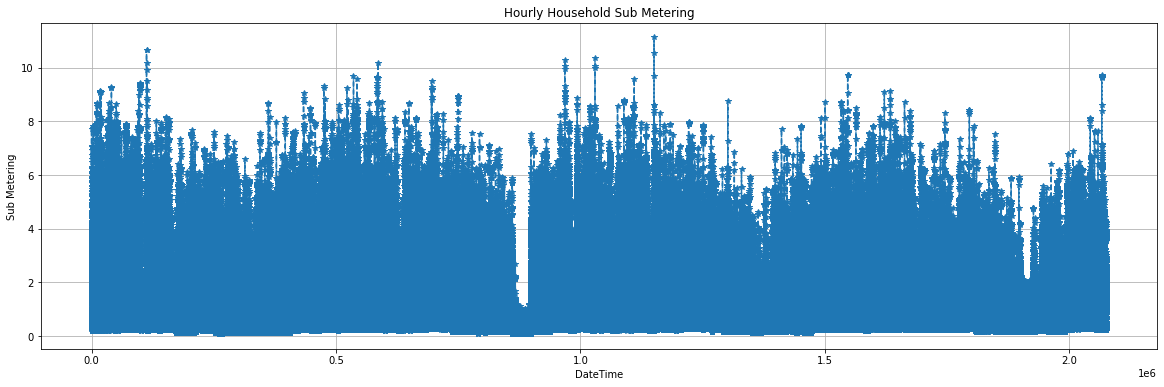

In [34]:
#Plot datetime X  average sub metering
plt.figure(figsize=(20,6))
plt.plot(energy.index, energy.Global_active_power, '--', marker='*', )
plt.grid()
plt.title("Hourly Household Sub Metering")
plt.xlabel('DateTime')
plt.ylabel('Sub Metering')

Text(0, 0.5, 'Global_active_power')

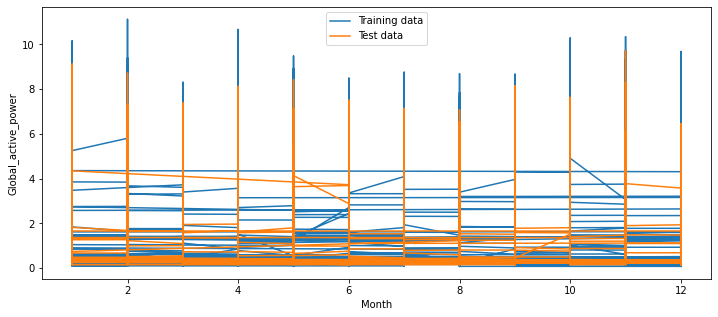

In [63]:
fig = plt.figure(figsize=(12, 5))
plt.plot(train['Month'], train['Global_active_power'], label='Training data')
plt.plot(test['Month'], test['Global_active_power'], label='Test data')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Global_active_power')